# Importing libraries

In [ ]:
%pip install osmnx
%pip install rasterio
%pip install rasterstats
%pip install contextily
%pip install geopandas
%pip install matplotlib

In [7]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
from shapely.geometry import box
import contextily as ctx
import rasterio
import geopy.distance
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Data

In [8]:
EV_ukr = 135200
population_ukr = 31000000
EV_per_capita_ukr = EV_ukr/population_ukr
print("Number of EV per capita:", round(EV_per_capita_ukr, 5))

Number of EV per capita: 0.00436


In [9]:
city_data_lviv = {
    "place": 'Lviv, Ukraine',
    "grid_size": 0.0125,
    # "EV_per_capita": EV_per_capita_ukr,
    "EV_per_capita": 0.010,
    # "distance_matrix": "distance_matrix_lviv_not_directed.npy",
    "distance_matrix": "distance_matrix_lviv.npy",
    "raster_file_population": "ukr_ppp_2020_constrained.tif"
} 

EV_data_lviv = {
    "avg_consumption_per_km": 159.9,
    "avg_distance_per_day": 33,
    "max_distance_to_charger": 3000
}

CS_data_lviv = {
    "energy_loss": 0.1,
    "station_utilization_rate": 0.15,
    "max_stations_num": 4,
    "CS_list": ["Level_2 7.4kW", "Level_2 22kW", "Level_2 50kW", "Level_3 60kW", "Level_3 120kW", "Level_3 160kW"],
    "Level_2 7.4kW": {"cost":2000, "capacity":7.4*1000, "voltage": 240},
    "Level_2 22kW": {"cost":5000, "capacity":22*1000, "voltage": 240},
    "Level_2 50kW": {"cost":7200, "capacity":50*1000, "voltage": 240},
    "Level_3 60kW": {"cost":10000, "capacity":60*1000, "voltage": 480},
    "Level_3 120kW": {"cost":30000, "capacity":120*1000, "voltage": 480},
    "Level_3 160kW": {"cost":50000, "capacity":160*1000, "voltage": 480},
    # "installed_stations": "station_location_lviv.csv"
    "installed_stations": None
}

model_parameters_lviv = {
    "alpha": 0.001,
    "beta": 5000,
    "gamma": 10,
    "delta": 3,
    "iterations": 10,
    "population_size": 10,
    "mutation_rate": 0.1
}

In [10]:
city_data = city_data_lviv
EV_data = EV_data_lviv
CS_data = CS_data_lviv
model_parameters = model_parameters_lviv

# City graph

In [11]:
G = ox.graph_from_place(city_data["place"], network_type="drive")

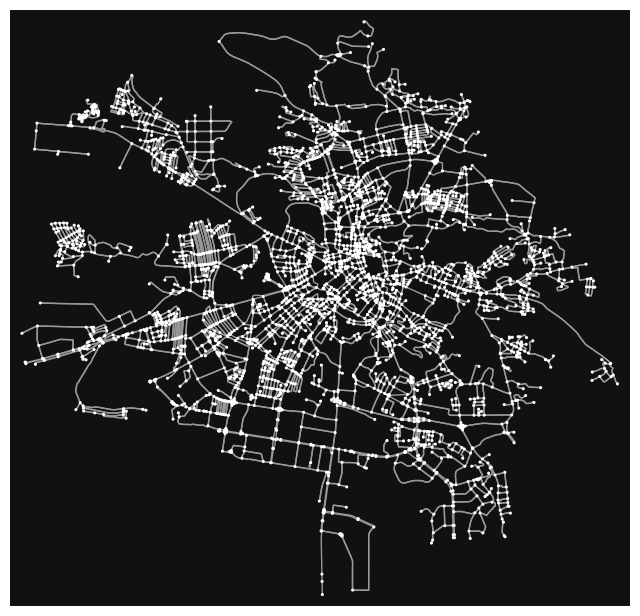

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
ox.plot_graph(G, node_size=5)

# Adding installed charging stations

**The form in which installed stations are presented:**\
$y\ =\ \{$ \
$\ \ \ \ (i, station\_capacity): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

In [13]:
def add_charging_stations(G, CS_data, visualization = True):
    charging_stations = pd.read_csv(CS_data["installed_stations"], sep = ";")
    # print(charging_stations.head())
    installed_cs = dict()
    installed_cs_list = []
    for row_index in range(len(charging_stations)):
        latitude = charging_stations['X'][row_index]
        longitude = charging_stations['Y'][row_index]
        num_of_chargers = charging_stations['Number'][row_index]
        cs_capacity = charging_stations['Capacity'][row_index]
        station_point = Point(longitude, latitude)

        # Найближче ребро (u, v, key) and its geometry
        u, v, key = ox.distance.nearest_edges(G, longitude, latitude)

        edge_data = G.get_edge_data(u, v, key)
        geom = edge_data.get("geometry", LineString([(G.nodes[u]['x'], G.nodes[u]['y']),
                                                    (G.nodes[v]['x'], G.nodes[v]['y'])]))

        # Найближча точка на ребрі
        line = LineString(geom)
        closest_point = line.interpolate(line.project(station_point))
        # new_node_id = (closest_point.x, closest_point.y)
        new_node_id = max(G.nodes) + 1
        G.add_node(new_node_id, x=closest_point.x, y=closest_point.y)

        # Поділ ребра на два ребра
        if G.has_edge(u, v, key):
            G.remove_edge(u, v, key)
            G.add_edge(u, new_node_id, length=line.project(closest_point))
            G.add_edge(new_node_id, v, length=line.length - line.project(closest_point))
        
        if G.has_edge(v, u, key):
            G.remove_edge(v, u, key)
            G.add_edge(v, new_node_id, length=line.project(closest_point))
            G.add_edge(new_node_id, u, length=line.length - line.project(closest_point))

        if new_node_id not in installed_cs_list:
            installed_cs_list.append(new_node_id)
        installed_cs[(new_node_id, cs_capacity)] = num_of_chargers

    if visualization:
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
        G_lviv_undirected = G.to_undirected()
        G_lviv_undirected.remove_edges_from(nx.selfloop_edges(G_lviv_undirected))
        fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

        nx.draw(G_lviv_undirected, pos, node_size=3, with_labels=False, node_color="white", edge_color="white", ax=ax)
        nx.draw_networkx_nodes(
        G_lviv_undirected, pos, nodelist=installed_cs_list, node_size=10, node_color="orange", label="Installed Stations", ax=ax)

        legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
        for text in legend.get_texts():
            text.set_color("white")

        plt.title("Graph with Installed Stations", color="white")
        ax.axis("off")
        fig.patch.set_facecolor("black")
        ax.set_facecolor("black")
        plt.tight_layout()
        plt.show()
    return G, installed_cs, installed_cs_list

# Calculating population for each region

### Division into sectors

In [14]:
def division_into_secors(city_data):
    city_boundary = ox.geocode_to_gdf(city_data["place"])

    xmin, ymin, xmax, ymax = city_boundary.total_bounds
    grid_size = 0.0125

    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=city_boundary.crs)
    map_with_grid = gpd.clip(grid, city_boundary)

    # ax = map_with_grid.plot(edgecolor="rosybrown", facecolor="none", figsize=(10, 10))
    # city_boundary.boundary.plot(ax=ax, color="maroon")
    # ctx.add_basemap(ax, crs=city_boundary.crs, source=ctx.providers.CartoDB.Positron)
    return map_with_grid, city_boundary

Assigning graph nodes to a grid cell (region)

In [15]:
def nodes_to_region(G, map_with_grid):
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

    nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
    nodes_in_grid = nodes_in_grid.reset_index()

    # Handling nodes that are not assigned to any grid cell. Creating node to region dictionary and region to nodes dictiionary
    assigned_nodes = nodes_in_grid.dropna(subset=['index_right']) 
    missing_nodes = nodes_in_grid[nodes_in_grid['index_right'].isna()]

    tree = cKDTree(assigned_nodes[['x', 'y']].values)
    _, nearest_idx = tree.query(missing_nodes[['x', 'y']].values)

    nodes_in_grid.loc[nodes_in_grid['index_right'].isna(), 'index_right'] = assigned_nodes.iloc[nearest_idx]['index_right'].values
    nodes_in_grid['index_right'] = nodes_in_grid['index_right'].astype(int)

    # region -> list of nodes
    region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)['osmid'].apply(list).to_dict()
    # node -> region DI
    node_to_region = nodes_in_grid.set_index('osmid')['index_right'].to_dict()
    regions = [region for region in region_to_nodes]
    return regions, region_to_nodes, node_to_region


In [16]:
# map_with_grid = map_with_grid.to_crs(epsg=4326)
# edges_gdf = edges_gdf.to_crs(map_with_grid.crs)
# fig, ax = plt.subplots(figsize=(12, 10))

# map_with_grid.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.7, label="Grid")

# edges_gdf.plot(ax=ax, color="darkgray", linewidth=1, alpha=0.8, label="Road Network")
# nodes_gdf.plot(ax=ax, color="red", markersize=5, alpha=0.6, label="Nodes")

# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

# ax.set_title(f"Road Network and Grid Overlay in {city_data['place']}", fontsize=14)
# ax.legend()
# plt.show()


### Population for each region

In [17]:
def population_estimation(regions, map_with_grid, city_boundary, city_data, visualization = False):
    # Population count for each sector
    raster_file_population = city_data["raster_file_population"]
    with rasterio.open(raster_file_population) as data:
        affine = data.transform
        array = data.read(1)
    stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
    map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]

    # Calculation of the number of EV for each sector
    map_with_grid["EV"] = map_with_grid["population"] *city_data["EV_per_capita"]

    map_with_grid = map_with_grid.reset_index()
    region_to_populatoin = dict()
    for grid_cell in range(len(map_with_grid)):
        region_id = map_with_grid.iloc[grid_cell]['index']
        if region_id in regions:
            population = map_with_grid.iloc[grid_cell]['population']
            region_to_populatoin[region_id] = population

    if visualization:
        ax = map_with_grid.plot(column="EV", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
        city_boundary.boundary.plot(ax=ax, color="maroon")
        ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)
    
    # return region_to_EV
    return region_to_populatoin

In [18]:
# ax = map_with_grid.plot(column="charging_capacity_demand", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
# city_boundary.boundary.plot(ax=ax, color="maroon")
# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

# Distance matrix

In [19]:
from scipy.sparse.csgraph import floyd_warshall
# G = ox.graph_from_place('Dnipro, Ukraine', network_type='drive')
def calculate_distamnce_matrix(G):
    nodes = list(G.nodes)
    n = len(nodes)
    print(f"Number of nodes: {n}")

    node_index = {node: idx for idx, node in enumerate(nodes)}
    print("Creating adjacency matrix")
    # Create adjacency matrix
    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = round(data.get("length", np.inf),2)
        i, j = node_index[u], node_index[v]
        D[i, j] = length
        D[j, i] = length  # Add for undirected graphs

    np.fill_diagonal(D, 0)  # Set diagonal to 0
    print("Using optimized Floyd-Warshall")
    # Use optimized Floyd-Warshall
    np.save("distance_matrix_lviv_not_directed.npy", D)
    return D
# np.save("distance_matrix_lviv1.npy", distance_matrix1(G))


In [20]:
def distance_matrix(G, city_data):
    if city_data["distance_matrix"]:
        return np.load(city_data["distance_matrix"])
    return calculate_distamnce_matrix(G)

# Substations

In [21]:
def find_substations(city_name):
    substations = ox.features_from_place(city_name, tags={"power": "substation"})
    # substations = substations[substations.geometry.notnull()]["geometry"]
    substations = substations[['geometry']].reset_index()
    return substations

In [22]:
def calculate_distance_to_substation(G, substations):
    dist_to_substation = dict()
    for node in G.nodes():
        node_lat, node_lon = G.nodes[node]['y'], G.nodes[node]['x']
        distances = []
        for _, row in substations.iterrows():
            if row.geometry.geom_type == "Point":  # Ensure it's a point geometry
                substation_lat, substation_lon = row.geometry.y, row.geometry.x
                distance_m = geopy.distance.geodesic((node_lat, node_lon), (substation_lat, substation_lon)).m
                distances.append(distance_m)
        dist_to_substation[node] = min(distances)
    return dist_to_substation

# Demand simulation

In [23]:
def create_cs_dataframe(solution, installed_cs, CS_data):
    # Merge installed station and solution station data
    station_node_list = []
    capacity_list = []
    station_ports_list = []
    if installed_cs:
        for (station_node, capacity), station_ports in installed_cs.items():
            station_node_list.append(station_node)
            capacity_list.append(capacity)
            station_ports_list.append(station_ports)

    for (station_node, station_type), station_ports in solution.items():
        capacity=  CS_data[station_type]["capacity"]

        station_node_list.append(station_node)
        capacity_list.append(capacity)
        station_ports_list.append(station_ports)

    # Create station dataframes
    charging_station_data = {
        "cs_id": range(len(station_node_list)),
        "node": station_node_list,
        "capacity": capacity_list,
        "num_of_ports": station_ports_list,
    }
    charging_station_df = pd.DataFrame(charging_station_data)
    return charging_station_df

In [24]:
def create_cs_occupation_dataframe(charging_station_df):
    cs_occupation_df = pd.DataFrame(columns=["cs_id", "capacity", "port", "hour", "occupation_time"])
    
    for _, row in charging_station_df.iterrows():
        cs_id = row['cs_id']
        capacity = row['capacity']
        number_of_ports = int(row['num_of_ports'])

        # Creating rows for each port and hour
        for port in range(1, number_of_ports + 1):
            for hour in range(24):
                cs_occupation_df.loc[len(cs_occupation_df)] = {"cs_id": cs_id, "capacity": capacity, "port": port, "hour": hour, "occupation_time": 0.0}

    cs_occupation_df["cs_id"] = cs_occupation_df["cs_id"].astype(int)
    return cs_occupation_df

In [25]:
def find_reachable_nodes(nodes, nodes_dict, dist_matrix, two_way = True):
    reachable_nodes = dict()

    for start_node in nodes:
        start_node_id = nodes_dict[start_node]
        reachable = []

        for destination_node in nodes:
            destination_node_id = nodes_dict[destination_node]
            if dist_matrix[start_node_id, destination_node_id] < float('inf'):
                if not two_way or (two_way and dist_matrix[destination_node_id, start_node_id] < float('inf')):
                    reachable.append(destination_node)

        reachable_nodes[start_node] = reachable
    return reachable_nodes

In [26]:
def generate_route(ev, reachable_nodes):
    # random.seed(10)
    locations = []
    departure_times = []

    # Fron home
    home_location = ev['home_location']
    morning_commute_hour = ev['commute_hours']['morning']

    
    # Route destinations
    number_of_destinations = random.choices([1, 2, 3], weights = [0.6, 0.3, 0.1], k=1)[0]
    
    locations.append(home_location) # Home location
    random_locations = random.choices(reachable_nodes[home_location], k = number_of_destinations) # Work and other locations
    for location in random_locations:
        while location == home_location:
                location = random.choice(reachable_nodes[home_location])
        locations.append(location)
    locations.append(home_location) # Home location


    # Route times
    trip_time = {
        "random morning trip": range(0, ev['commute_hours']['morning']),
        "random noon trip": range(ev['commute_hours']['morning'], ev['commute_hours']['evening']),
        "random evening trip": range(ev['commute_hours']['evening'], 24)

    }
    
    departure_times.append(morning_commute_hour) # Departure from home

    if number_of_destinations > 1:
        for i in range(number_of_destinations-1):
            ranom_trip_type = random.choice(["random morning trip", "random noon trip", "random evening trip"])
            random_trip_time = random.choice(trip_time[ranom_trip_type])
            departure_times.append(random_trip_time)

    departure_times.append(ev['commute_hours']['evening']) # Departure from work
    departure_times.sort()

    parking_periods = []
    for i in range(number_of_destinations + 2): # +2 since the route starts and ends at home
        if i == 0:
            parking_periods.append([0, departure_times[i]-1])
        elif i == number_of_destinations + 1:
            parking_periods.append([departure_times[i-1], 23])
        else:
            parking_periods.append([departure_times[i-1], departure_times[i]-1])
    return locations, parking_periods

In [27]:
def generate_EVs(regions, region_to_population, city_data, region_to_nodes, reachable_nodes, avg_battery_capacity):
    # random.seed(12)
    EVs = []
    ev_id = 0

    for region in regions:
        ev_num = int(region_to_population[region] * city_data["EV_per_capita"])

        valid_home_locations = [node for node in region_to_nodes[region] if len(reachable_nodes[node])>=10]
        if len(valid_home_locations) == 0:
            break
        ev_home_locations = random.choices(valid_home_locations, k = ev_num)
        for i in range(ev_num):
            ev = {
                    'ev_id': ev_id,
                    'home_location': ev_home_locations[i],
                    'previous_location': ev_home_locations[i],
                    'battery_capacity': avg_battery_capacity * (0.8 + 0.4 * random.random()),  # Small variation in battery size
                    'current_charge': avg_battery_capacity * (0.3 + 0.7 * random.random()),  # Random initial charge
                    'charging_threshold': 0.2 + 0.1 * random.random(),  # When to start charging (20-30% of capacity)
                    'target_charge': 0.8 + 0.2 * random.random(),  # Target charge level (80-100%)
                    'commute_hours': {
                        'morning': 6 + int(4 * random.random()),  # Morning commute hour (6-9 AM)
                        'evening': 16 + int(4 * random.random())  # Evening commute hour (4-7 PM)
                    },
                    'destinations': None, # Will be assigned below
                    'parking_periods': None # Will be assigned below
            }

            # Assign route (destinations + departure_times)
            destinations, parking_periods = generate_route(ev, reachable_nodes)
            ev['destinations'] = destinations
            ev['parking_periods'] = parking_periods
            EVs.append(ev)
            ev_id +=1
    return EVs

In [28]:
def needs_charge(ev):
    return (ev['current_charge'] < ev['battery_capacity']*ev['charging_threshold'])

In [29]:
def nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_dict):
    nearest_cs = charging_station_df.copy()
    cs_nodes = nearest_cs["node"]

    distance = [dist_matrix[nodes_dict[current_location], nodes_dict[cs_node]] for cs_node in cs_nodes]
    nearest_cs['distance'] = distance
    nearest_cs = nearest_cs.sort_values(by = ['distance', 'capacity'], ascending=[True, False])
    
    return nearest_cs[nearest_cs["distance"] < float('inf')]

In [30]:
def charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, CS_data):
    # Calculating needed energy
    energy_needed = ev['battery_capacity'] * ev['target_charge'] - ev['current_charge']
    total_energy_needed = energy_needed/(1-CS_data['energy_loss'])
    
    # Calculating departure time (from charging station to next location)
    for j in range(len(ev['parking_periods'])):
        parking_period_start, parking_period_end = ev['parking_periods'][j]
        if hour in range(parking_period_start, parking_period_end + 1):
            departure_time = parking_period_end + 1

    # Searching for a nearest charging station
    while True:
        if len(nearest_cs_df) == 0:
            print('No charhing station is reachable')
            return charging_session_df, cs_occupation_df, ev

        for i in range(len(nearest_cs_df)):
            charging_station_data = nearest_cs_df.iloc[i]
            cs_node = charging_station_data['node']
            cs_id = charging_station_data['cs_id']
            cs_capacity = charging_station_data['capacity']
            num_of_ports = int(charging_station_data['num_of_ports'])
            distance = charging_station_data['distance']
            # Searching for a free port
            for port in range(1, num_of_ports + 1):
                port_occupation_data = cs_occupation_df[(cs_occupation_df['cs_id']==cs_id) & (cs_occupation_df['hour']==hour)&(cs_occupation_df['port']==port)]
                port_occupation_time = port_occupation_data['occupation_time'].iloc[0]
                if port_occupation_time < 60:
                    break
            if port_occupation_time < 60:
                break


        # If at the current hour each port is occupied for 60 minutes
        # then it is necessary to search for a free port in the next hour, if the day hasn't ended
        if port_occupation_time != 60:
            break
        else:
            if hour + 1 < 24 and hour + 1 < departure_time:
                hour +=1
            else:
                return charging_session_df, cs_occupation_df, ev
        
            
    # Calculating charging time
    charging_time_minutes = (total_energy_needed/cs_capacity)*60
    # EV charges until it is time for the next trip or until it is charged
    charging_time_minutes = min(charging_time_minutes, max(0, (departure_time - hour)*60 - port_occupation_time))

    # Update charging station occupation dataframe
    if port_occupation_time + charging_time_minutes <=60:
        cs_occupation_df.loc[(cs_occupation_df['cs_id'] == cs_id) & (cs_occupation_df['hour'] == hour) & (cs_occupation_df['port'] == port),\
                              'occupation_time'] = port_occupation_time + charging_time_minutes
        charging_end_hour = hour
    else:
        cs_occupation_df.loc[(cs_occupation_df['cs_id'] == cs_id) & (cs_occupation_df['hour'] == hour) & (cs_occupation_df['port'] == port),\
                              'occupation_time'] = 60
        charging_time_left = charging_time_minutes + port_occupation_time - 60
        next_hour = hour + 1
        while charging_time_left > 60 and next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df['cs_id'] == cs_id) & (cs_occupation_df['hour'] == next_hour) & (cs_occupation_df['port'] == port),\
                              'occupation_time'] = 60
            charging_time_left -= 60
            next_hour +=1
        if next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df['cs_id'] == cs_id) & (cs_occupation_df['hour'] == next_hour) & (cs_occupation_df['port'] == port),\
                              'occupation_time'] = charging_time_left
        charging_end_hour = min(23, next_hour)

    # Add new session
    new_session = {
        "cs_id": cs_id,
        "node": cs_node,
        "capacity": cs_capacity,
        "port": port,
        "charging_start_hour": hour,
        "charging_end_hour": charging_end_hour,
        "session_duration": charging_time_minutes,
        "ev_id": ev['ev_id'],
        "distance_from_ev": distance,
        "energy_used": cs_capacity*(charging_time_minutes/60)
    }
        
    charging_session_df.loc[len(charging_session_df)] = new_session
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    # charging_session_df["node"] = charging_session_df["node"].astype(int)
    # Update EV data
    ev['current_charge'] = ev['current_charge'] + cs_capacity*(charging_time_minutes/60)
    ev['previous_location'] = cs_node


    return charging_session_df, cs_occupation_df, ev

In [31]:
def simulate_ev_charging_demand(solution, CS_data, region_to_population, node_to_region, region_to_nodes, dist_matrix,
                                nodes_dict, EV_data, installed_cs = None, simulation_hours=24, avg_battery_capacity=60000):
    """
    A simple simulation model for EV charging demand over a 24-hour period.
    
    Parameters:
    -----------
    simulation_hours : int
        Number of hours to simulate (typically 24)
    avg_daily_miles : float
        Average miles driven per day per EV
    kwh_per_mile : float
        Average energy consumption per mile (kWh)
    avg_battery_capacity : float
        Average EV battery capacity in kWh
    home_charging_probability : float
        Probability that an EV will charge at home overnight
    
    Returns:
    --------
    DataFrame with hourly charging demand per node
    """
    random.seed(12)
    regions = list(region_to_population.keys())
    nodes = list(node_to_region.keys())
    reachable_nodes = find_reachable_nodes(nodes, nodes_dict, dist_matrix, two_way = True)

    charging_station_df = create_cs_dataframe(solution, installed_cs, CS_data)

    charging_session_df = pd.DataFrame(columns = ["cs_id", "node", "capacity", "port", "charging_start_hour", \
                                          "charging_end_hour", "session_duration", "ev_id", "distance_from_ev", "energy_used"])
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    charging_session_df["node"] = charging_session_df["node"].astype(int)

    cs_occupation_df = create_cs_occupation_dataframe(charging_station_df)

    # For each region initialize ev
    EVs = generate_EVs(regions, region_to_population, city_data, region_to_nodes, reachable_nodes, avg_battery_capacity)

    avg_consumption_per_km = EV_data["avg_consumption_per_km"] #Wh/km

    # Simulate each hour
    for hour in range(simulation_hours):

        # For each EV
        for i in range(len(EVs)):
            ev = EVs[i]
            
            previous_location = ev['previous_location']
            # Update location and state of charge
            for j in range(len(ev['parking_periods'])):
                parking_period_start, parking_period_end = ev['parking_periods'][j]
                if hour in range(parking_period_start, parking_period_end + 1):
                    current_location = ev['destinations'][j]
                    break
            if previous_location != current_location:
                distance = dist_matrix[nodes_dict[previous_location], nodes_dict[current_location]]
                energy_used = distance * (avg_consumption_per_km/1000)
                ev['current_charge'] -= energy_used

            # Charge if needed
            if needs_charge(ev):
                # print("I need to charge :(")
                nearest_cs_df = nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_dict)
                charging_session_df, cs_occupation_df, ev = charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, CS_data)


            ev['previous_location'] = current_location
    
    return cs_occupation_df, charging_session_df

# Fitness Evaluation

### 1) CS cost evaluation

Total CS cost:\
$cs\_cost = \sum^N_{i=1}\sum_{n \in cs\_type} cost_{n,i}*X_{n,i}$

In [32]:
def cs_cost_penalty(solution, CS_data):
    total_cost = 0
    for charging_station in solution:
        cs_type = charging_station[1]
        cost = CS_data[cs_type]["cost"]
        number_of_stations = solution[charging_station]
        total_cost += cost*number_of_stations
    return total_cost

### 2) Average charging time per 1kWh evaluation

In [33]:
def avg_time_per_kWh(charging_session_data):
    return sum(charging_session_data["session_duration"])/(sum(charging_session_data["energy_used"])/1000)

### 3) Average distance to charging station evaluation

In [34]:
def average_distance_to_cs(charging_session_data):
    return charging_session_data['distance_from_ev'].mean()

### 4) Grid loss

In [35]:
def total_grid_loss(solution, distance_to_substations):
    total_distance = 0
    for station in solution:
        cs_node = station[0]
        total_distance += distance_to_substations[cs_node]
    return total_distance

### Evaluation function

$evaluation = \alpha*cs\_cost + \beta*avg\_time\_per\_kWh + \gamma*avg\_distance + \delta*grid\_loss$

In [36]:
def evaluate_fitness(solution, parameters, CS_data, EV_data, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_dict, distance_to_substations, installed_stations):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    gamma = parameters["gamma"]
    delta = parameters["delta"]

    cs_occupation_df, charging_session_data = simulate_ev_charging_demand(solution, CS_data, region_to_population, node_to_region, region_to_nodes,
                                dist_matrix, nodes_dict, EV_data, installed_stations, simulation_hours=24, avg_battery_capacity=60000)

    cs_cost = cs_cost_penalty(solution, CS_data)
    avg_charging_time_kWh = avg_time_per_kWh(charging_session_data)
    avg_distance= average_distance_to_cs(charging_session_data)
    grid_loss = total_grid_loss(solution, distance_to_substations)
    # print("cs_cost: ", alpha*cs_cost)
    # print("avg_charging_time_kWh: ", beta*avg_charging_time_kWh)
    # print("avg_distance: ", gamma*avg_distance)

    fitness = alpha*cs_cost + beta*avg_charging_time_kWh + gamma*avg_distance + delta*grid_loss
    return fitness, alpha*cs_cost, beta*avg_charging_time_kWh, gamma*avg_distance, delta*grid_loss

# Genetic Algorithm

## Initialization

- 30 solutions
- 5-100 random stations for each solution
- random cs type

In [37]:
def initialize_population(nodes, station_types, population_size = 30):
    population = []
    for i in range(population_size):
        solution = {}
        for node in random.sample(nodes, k=random.randint(5, 100)):
            cs_type = random.choice(station_types)
            cs_number = random.choices([1,2,3], [0.6, 0.3, 0.1])[0]
            solution[(node, cs_type)] = cs_number
        population.append(solution)
    return population

## Selection

In [38]:
def select_parents(population, fitness):
    # Invert fitness values (since lower fitness is better)
    adjusted_fitness = [1/f for f in fitness]

    total_adjusted_fitness = sum(adjusted_fitness)
    probabilities = [solution_fitness/total_adjusted_fitness for solution_fitness in adjusted_fitness]

    size = int(len(population)//2)
    size = size + size%2 # even number of parents
    indices = np.random.choice(len(population), size=size, p=probabilities, replace=True)
    parents = [population[i] for i in indices]
    return parents

## Crossover

In [39]:
def crossover(parent1, parent2):
    cs_list_1, cs_list_2 = list(parent1.keys()), list(parent2.keys())
    split1 = len(cs_list_1)//2
    split2 = len(cs_list_2)//2

    child = {**{cs: parent1[cs] for cs in cs_list_1[:split1]}, **{cs: parent2[cs] for cs in cs_list_2[split2:]}}
    return child

## Mutation

In [40]:
def mutate(solution, nodes, cs_types, mutation_rate=0.1):
    if random.random() < mutation_rate:
        if random.random() < 0.4:  # Remove a random stations
            num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]
            for i in range(num_of_stations):
                random_cs = random.choice([cs for cs in solution])
                num_of_ports = random.choice(range(0, solution[random_cs]))
                if num_of_ports < solution[random_cs]:
                    solution[random_cs] = solution[random_cs] - num_of_ports
                else:
                    solution.pop(random_cs)
        else:  # Add a new stations
            num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]
            for i in range(num_of_stations):
                random_node = random.choice(nodes)
                cs_type = random.choice(cs_types)
                num_of_ports = random.choice(range(1, 2))
                if (random_node, cs_type) in solution:
                    solution[(random_node, cs_type)] = min(4, solution[(random_node, cs_type)] + num_of_ports)
                else: 
                    solution[(random_node, cs_type)] = num_of_ports
    return solution

## GA

In [41]:
def genetic_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters, region_to_population, node_to_region, region_to_nodes, distance_to_substations, installed_cs = False):
    nodes = list(G.nodes)
    nodes_dict = {nodes[i]: i for i in range(len(nodes))}

    population = initialize_population(nodes, CS_data["CS_list"], population_size = model_parameters["population_size"])

    # fitness evaluation for plot
    fitness = [evaluate_fitness(solution, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_population, node_to_region, region_to_nodes, nodes_dict, distance_to_substations, installed_cs) for solution in population]
    total_fitness = [solution_fitness[0] for solution_fitness in fitness]
    best_solution = population[np.argmin(total_fitness)]
    best_fitness_list = [fitness[np.argmin(total_fitness)]]
    iterations = model_parameters["iterations"]
    for generation in range(iterations):
        print("Iteration", generation + 1, "/", iterations)

        parents = select_parents(population, total_fitness)
        offsprings = []
        for i in range(0, len(parents), 2):
            if i + 1 < len(parents):
                offspring = crossover(parents[i], parents[i + 1])
                offsprings.append(offspring)
        offsprings = [mutate(offspring, nodes, CS_data["CS_list"], model_parameters["mutation_rate"]) for offspring in offsprings]
        population = population + offsprings

        offspring_fitness = [evaluate_fitness(offspring, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_population, node_to_region, region_to_nodes, nodes_dict, distance_to_substations, installed_cs) for offspring in offsprings]
        fitness = fitness + offspring_fitness

        # selecting solutions that remain in the population
        best_indices = np.argsort([solution_fitness[0] for solution_fitness in fitness])[:model_parameters["population_size"]]
        population = [population[i] for i in best_indices]
        fitness = [fitness[i] for i in best_indices]

        # fitness evaluation for plot
        total_fitness = [solution_fitness[0] for solution_fitness in fitness]
        best_solution = population[np.argmin(total_fitness)]
        best_fitness_list.append(fitness[np.argmin(total_fitness)])


    return best_solution, best_fitness_list


# Visualization

In [42]:
def visualize_solution(solution, G, installed_cs_list = None):

    cs_lists_by_type = dict()
    for charging_station in solution:
        cs_node = charging_station[0]
        cs_type = charging_station[1]
        if cs_type in list(cs_lists_by_type.keys()):
            cs_lists_by_type[cs_type].append(cs_node)
        else:
            cs_lists_by_type[cs_type] = [cs_node]


    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

    nx.draw(G_undirected, pos, node_size=5, with_labels=False, node_color="white", edge_color="white", ax=ax)
    
    # Installed stations
    if installed_cs_list:
        nx.draw_networkx_nodes(
            G_undirected, pos, nodelist=installed_cs_list, node_size=20, node_color="orange", label="Initially Installed Stations", ax=ax
        )

    for cs_type in cs_lists_by_type:
        nx.draw_networkx_nodes(
            G_undirected, pos, nodelist=cs_lists_by_type[cs_type], node_size=20, label=f"{cs_type} Stations", ax=ax
        )


    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("white")

    plt.title("Graph with Stations", color="white")
    ax.axis("off")

    fig.patch.set_facecolor("black")
    ax.set_facecolor("black")

    plt.tight_layout()
    plt.show()

In [43]:
def plot_total_fitness(best_fitness_list):
    plt.figure(figsize=(15, 10))
    fitness = [iteration[0] for  iteration in best_fitness_list]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Total Fitness of the best solution for each iteration for GA model')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [44]:
def plot_models_fitness(best_fitness_lists, parameters):
    m = len(best_fitness_lists)
    plt.figure(figsize=(15, 10))

    for i in range(m):
        
        fitness_list = best_fitness_lists[i]
        fitness = [iteration[0] for  iteration in fitness_list]
        fitness_cost = [iteration[1] for  iteration in fitness_list]
        fitness_charging_time = [iteration[2] for  iteration in fitness_list]
        fitness_avg_distance = [iteration[3] for  iteration in fitness_list]
        fitness_grid_loss = [iteration[4] for  iteration in fitness_list]
        n = parameters["iterations"] + 1
        if m > 1:
            plt.subplot((m+1)//2, 2, i+1)
        plt.plot(range(n), fitness, label = "Total evaluation")
        plt.plot(range(n), fitness_cost, label = f"Cost evaluation, weight = {parameters['alpha']}")
        plt.plot(range(n), fitness_charging_time, label = f"Average charging time per kWh evaluation, weight = {parameters['beta']}")
        plt.plot(range(n), fitness_avg_distance, label = f"Average distance evaluation, weight = {parameters['gamma']}")
        plt.plot(range(n), fitness_grid_loss, label = f"Grid loss evaluation, weight = {parameters['delta']}")

        plt.xlabel('Iteration')
        plt.ylabel('Best fitness')
        plt.title(f'Fitness values of the best solution for each iteration for GA model №{i+1}')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# GA Optimization model

In [46]:
def GA_optimization_model(city_data, EV_data, CS_data, model_parameters, n = 1):
    # Graph
    G = ox.graph_from_place(city_data["place"], network_type="drive")

    # Adding installed stations
    # G, installed_cs, installed_cs_list = add_charging_stations(G, CS_data, visualization = False)
    installed_cs = None
    G = G.to_undirected()
    # Calculating distance matrix
    dist_matrix = distance_matrix(G, city_data)
    # Calculating distance from nodes to substations
    substations = find_substations(city_data["place"])
    distance_to_substations = calculate_distance_to_substation(G, substations)
    # Division into sectors + demand estimation
    map_with_grid, city_boundary = division_into_secors(city_data)
    regions, region_to_nodes, node_to_region = nodes_to_region(G, map_with_grid)
    region_to_population = population_estimation(regions, map_with_grid, city_boundary, city_data, visualization = False)
    
    # GA
    best_fitness_lists = []
    for i in range (n):
        best_solution, best_fitness_list = genetic_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters,\
                                        region_to_population, node_to_region, region_to_nodes, distance_to_substations, installed_cs = installed_cs)
        best_fitness_lists.append(best_fitness_list)
        
    # Visualization
    plot_models_fitness(best_fitness_lists, model_parameters)
    for i in range(len(best_fitness_lists)):
        plot_total_fitness(best_fitness_lists[i])
    visualize_solution(best_solution, G, installed_cs_list = None)
    return best_solution

    

# Experiments

## Experiment 1

- Undirected graph
- No initially installed charging stations
- Lviv

- $mutation\ rate = 0.1$
- $10\ iterations$
- $population\ size = 10$
- $EV\ per\ capita = 0.010$


- $\alpha = 0.001$
- $\beta = 5000$
- $\gamma = 10$
- $\delta = 1$

In [192]:
model_parameters = {
    "alpha": 0.001,
    "beta": 5000,
    "gamma": 10,
    "delta": 1,
    "iterations": 10,
    "population_size": 10,
    "mutation_rate": 0.1
}

Iteration 1 / 10
Iteration 2 / 10
Iteration 3 / 10
Iteration 4 / 10
Iteration 5 / 10
Iteration 6 / 10
Iteration 7 / 10
Iteration 8 / 10
Iteration 9 / 10
Iteration 10 / 10


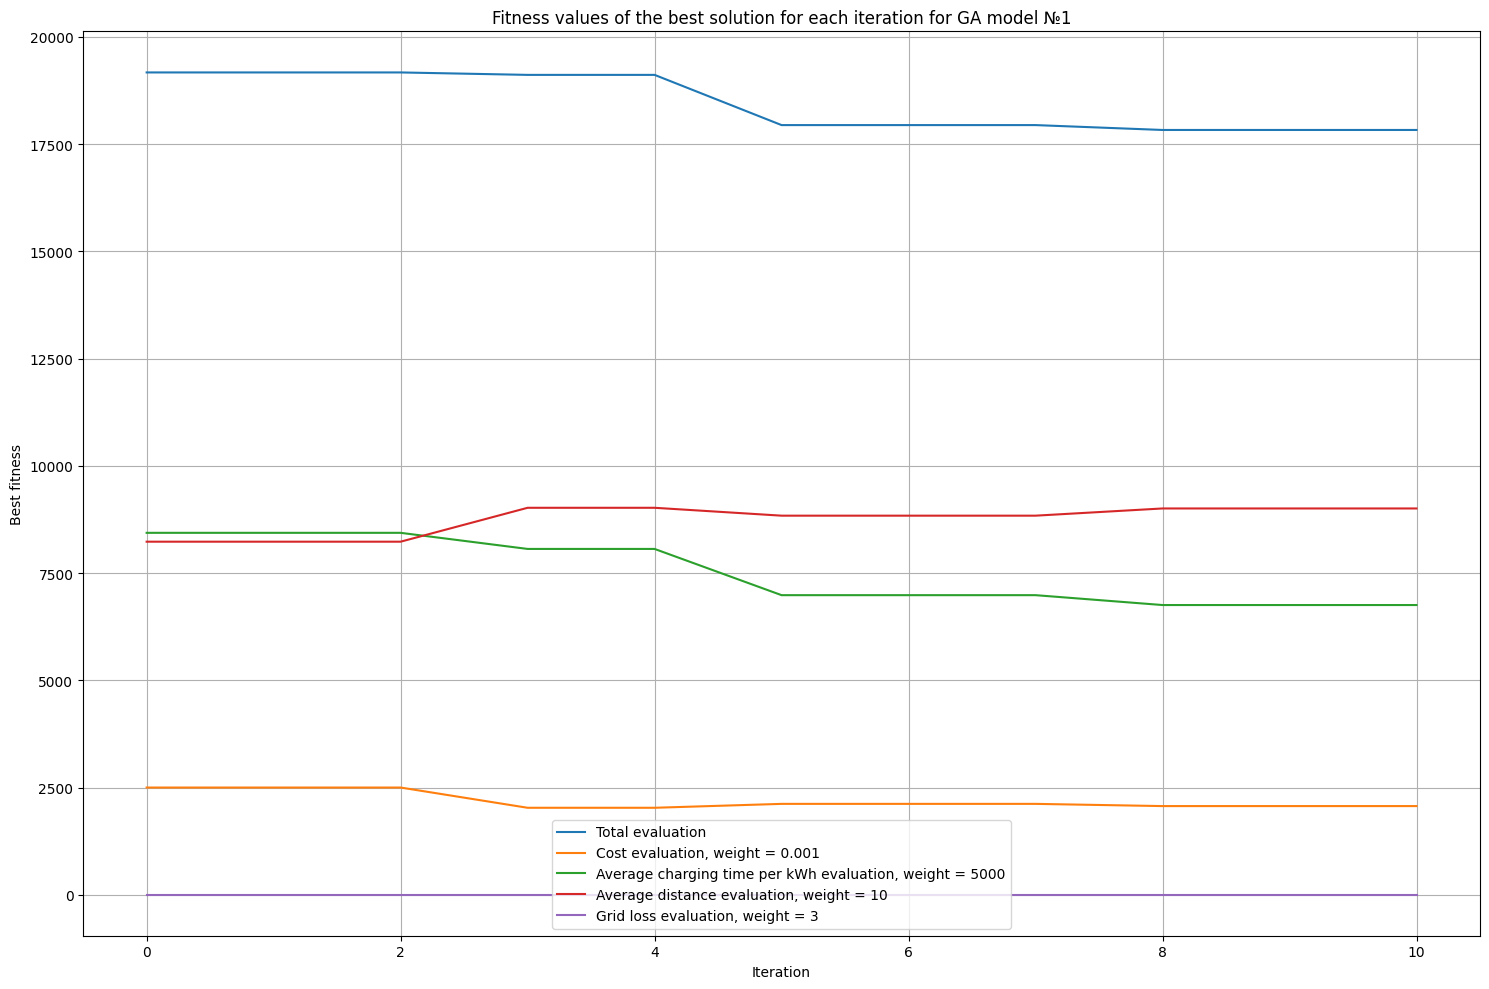

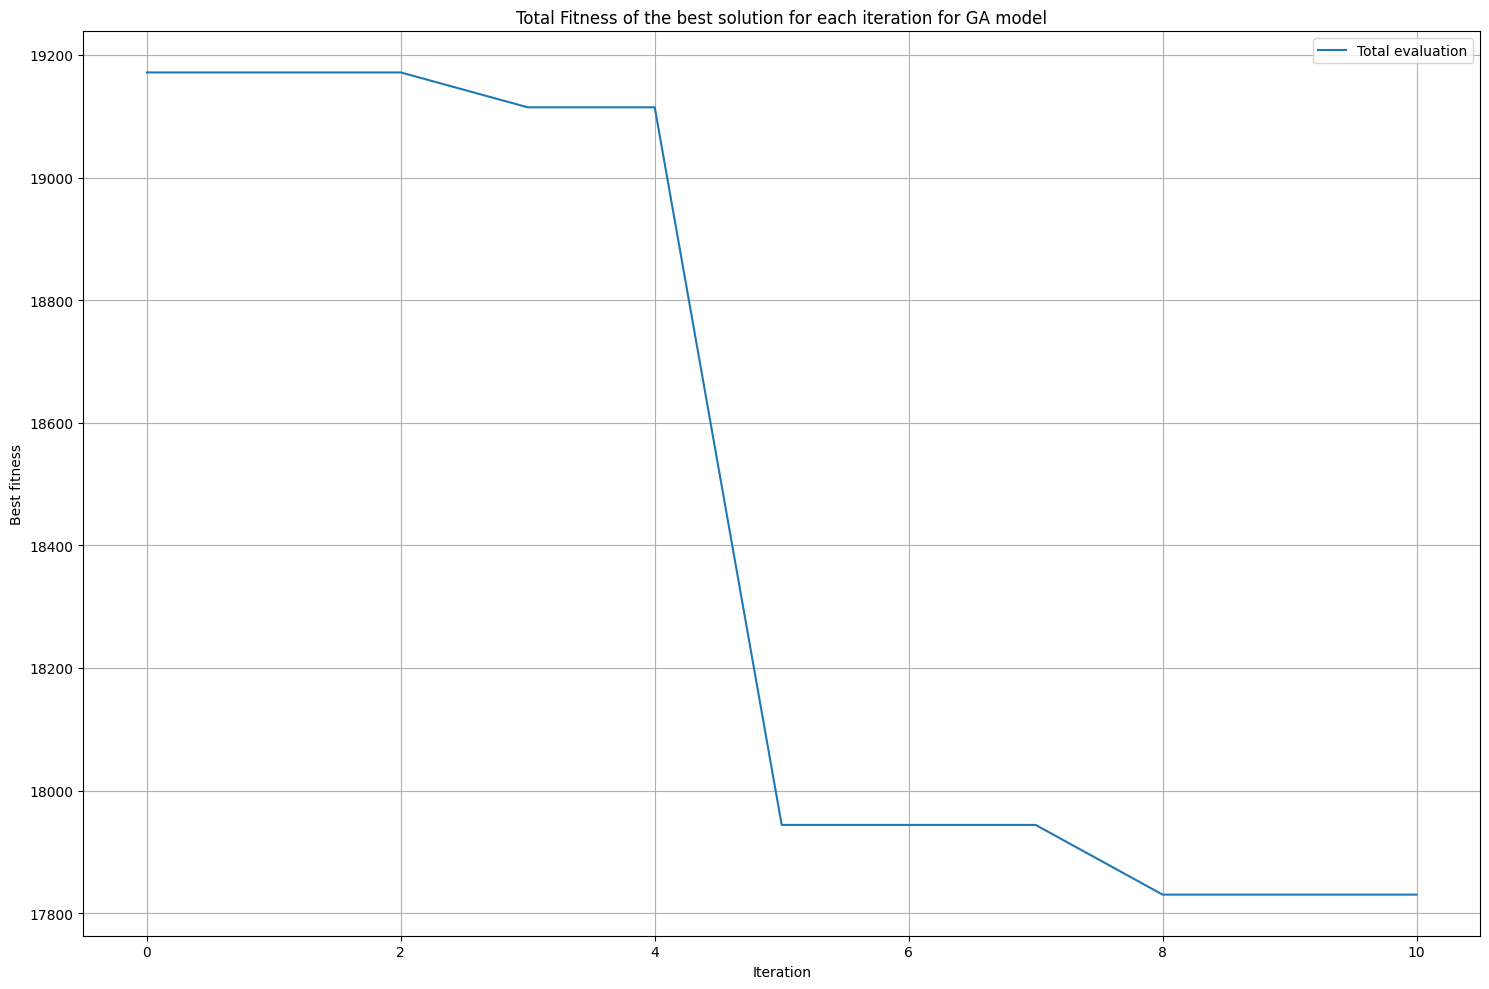

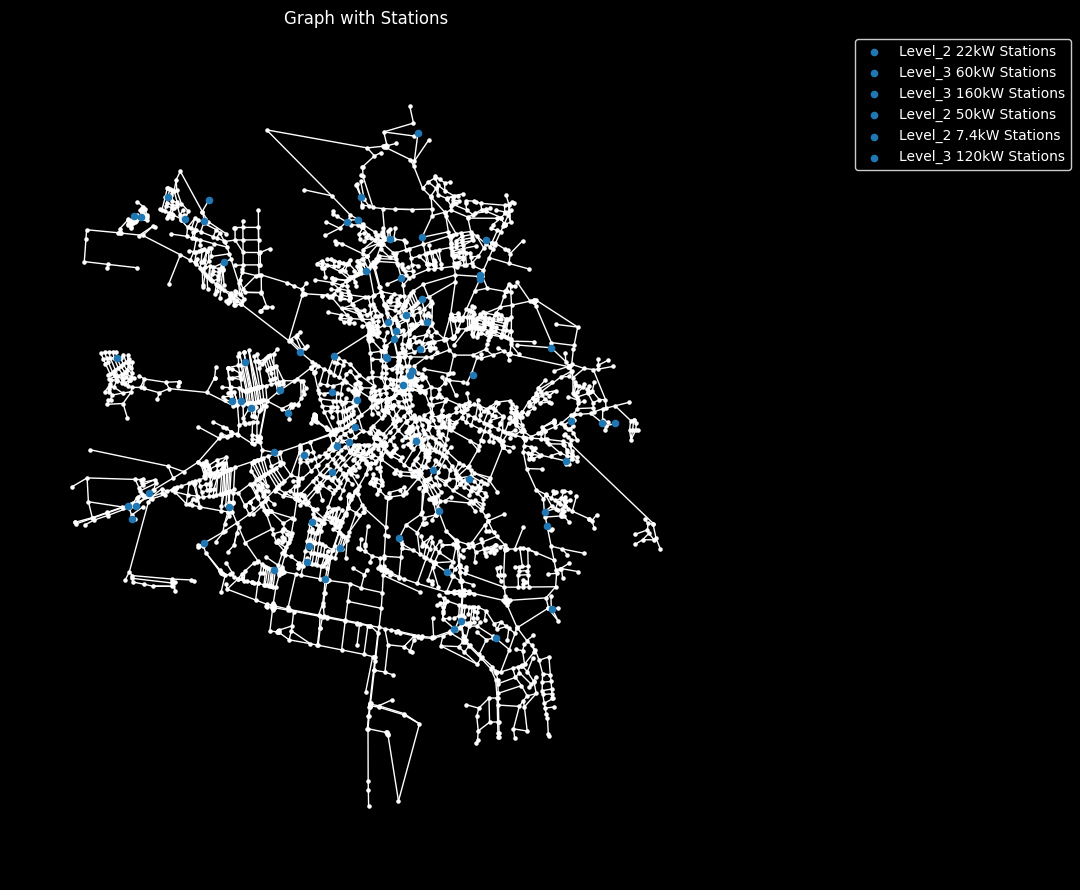

{(2813340590, 'Level_2 22kW'): 1,
 (722551462, 'Level_3 60kW'): 1,
 (1568276995, 'Level_3 160kW'): 1,
 (480137703, 'Level_2 50kW'): 1,
 (2588093803, 'Level_2 50kW'): 1,
 (1982879886, 'Level_2 22kW'): 3,
 (1533023044, 'Level_2 7.4kW'): 1,
 (1941112079, 'Level_2 50kW'): 1,
 (1935651072, 'Level_3 160kW'): 2,
 (5030650658, 'Level_2 7.4kW'): 1,
 (4583718370, 'Level_2 22kW'): 1,
 (1905690538, 'Level_2 22kW'): 2,
 (267371052, 'Level_3 60kW'): 2,
 (1568277020, 'Level_2 22kW'): 1,
 (2376255040, 'Level_2 22kW'): 1,
 (262975897, 'Level_3 60kW'): 1,
 (4749624205, 'Level_3 120kW'): 1,
 (2539412143, 'Level_2 7.4kW'): 1,
 (1809814478, 'Level_3 60kW'): 1,
 (1674985054, 'Level_3 120kW'): 3,
 (2466012230, 'Level_2 50kW'): 2,
 (1897922668, 'Level_3 160kW'): 1,
 (5659393466, 'Level_3 160kW'): 2,
 (708874516, 'Level_3 60kW'): 2,
 (1596335487, 'Level_3 60kW'): 2,
 (7982497168, 'Level_3 160kW'): 3,
 (257496318, 'Level_3 120kW'): 1,
 (2491426667, 'Level_2 7.4kW'): 1,
 (1942552801, 'Level_2 22kW'): 1,
 (261713

In [188]:
GA_optimization_model(city_data, EV_data, CS_data, model_parameters, n = 1)

## Experiment 2

- Undirected graph
- No initially installed charging stations
- Lviv

- $mutation\ rate = 0.1$
- $30\ iterations$
- $population\ size = 20$
- $EV\ per\ capita = 0.010$


- $\alpha = 0.001$
- $\beta = 5000$
- $\gamma = 10$
- $\delta = 1$

In [193]:
model_parameters = {
    "alpha": 0.001,
    "beta": 5000,
    "gamma": 10,
    "delta": 1,
    "iterations": 30,
    "population_size": 20,
    "mutation_rate": 0.1
}

Iteration 1 / 30
Iteration 2 / 30
Iteration 3 / 30
Iteration 4 / 30
Iteration 5 / 30
Iteration 6 / 30
Iteration 7 / 30
Iteration 8 / 30
Iteration 9 / 30
Iteration 10 / 30
Iteration 11 / 30
Iteration 12 / 30
Iteration 13 / 30
Iteration 14 / 30
Iteration 15 / 30
Iteration 16 / 30
Iteration 17 / 30
Iteration 18 / 30
Iteration 19 / 30
Iteration 20 / 30
Iteration 21 / 30
Iteration 22 / 30
Iteration 23 / 30
Iteration 24 / 30
Iteration 25 / 30
Iteration 26 / 30
Iteration 27 / 30
Iteration 28 / 30
Iteration 29 / 30
Iteration 30 / 30


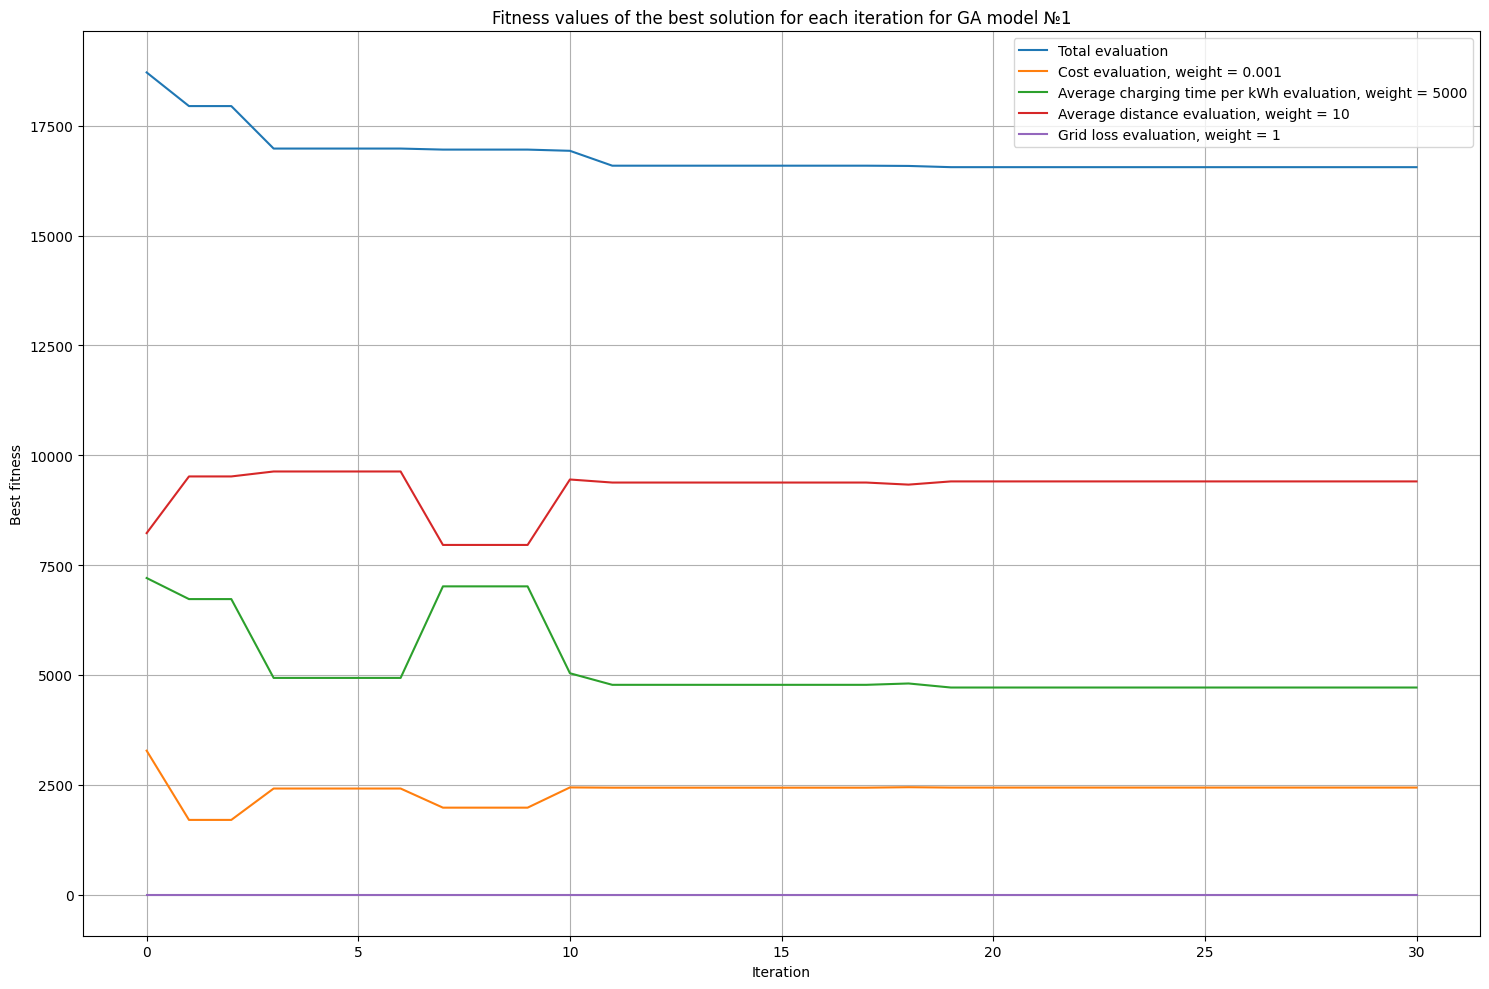

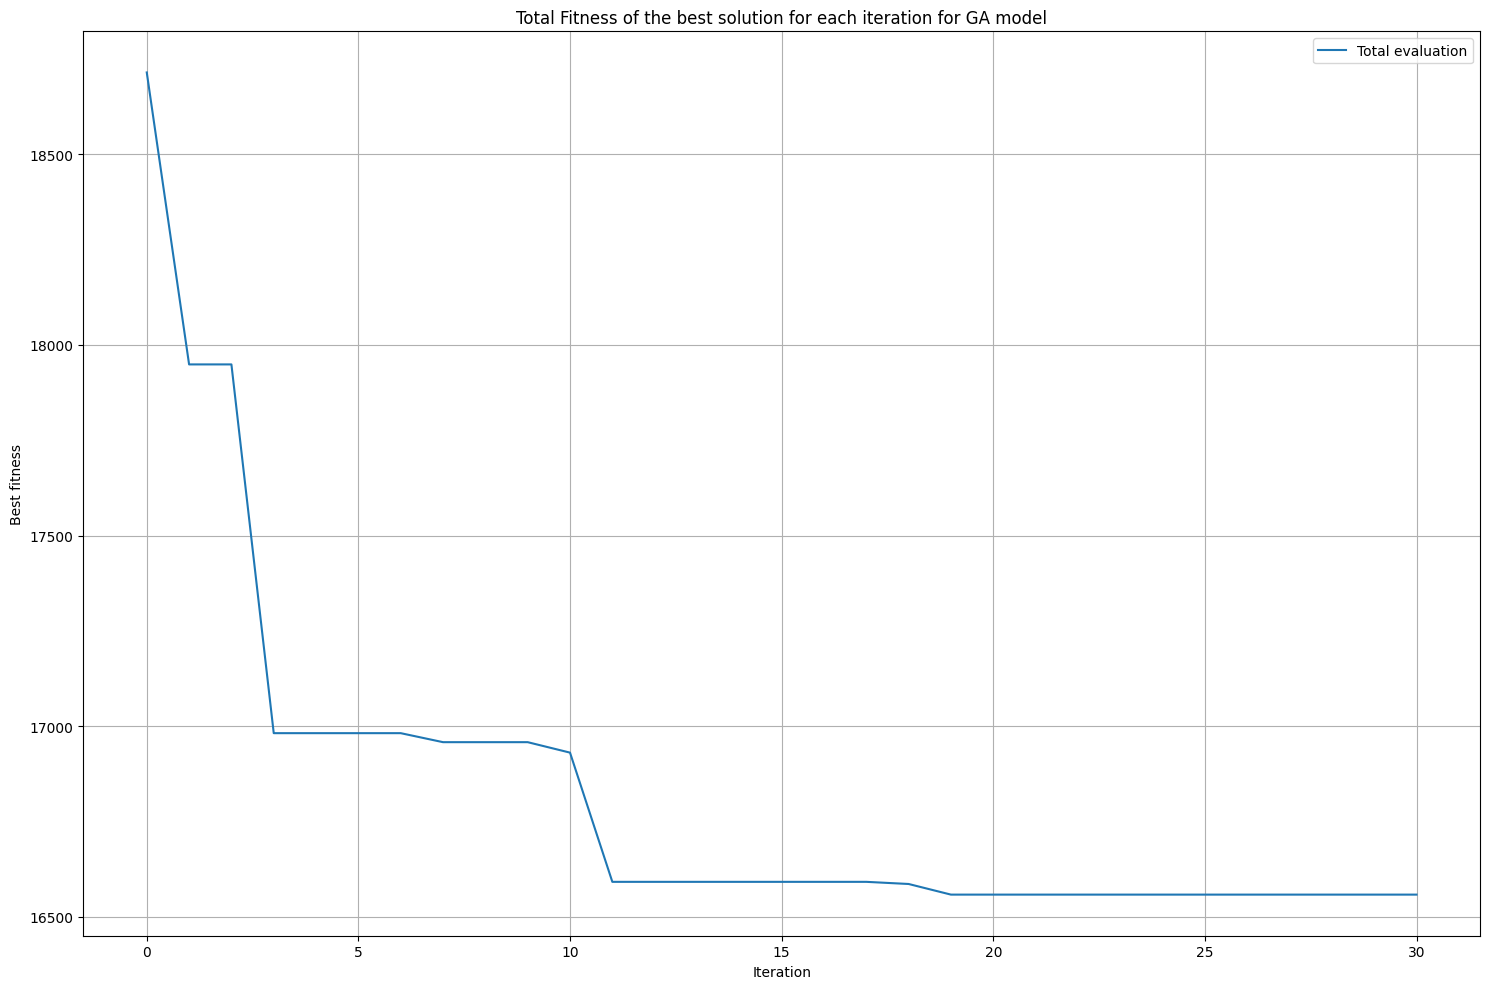

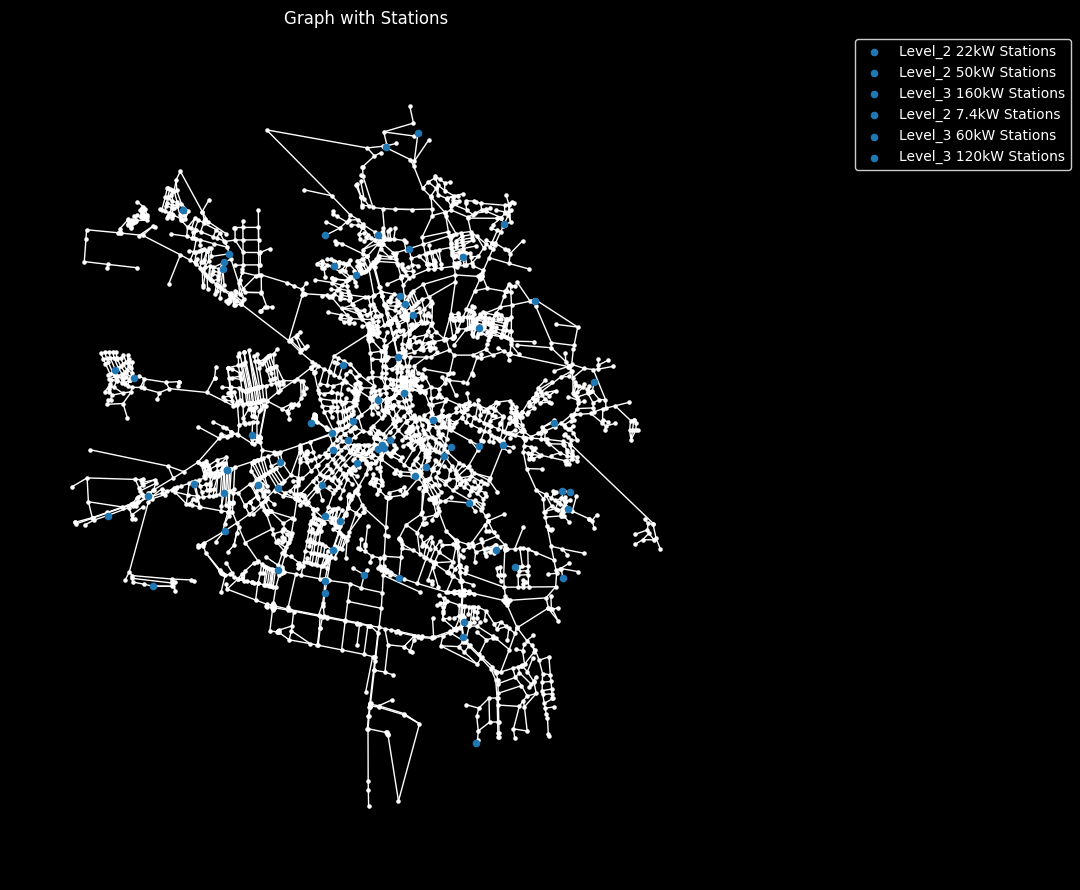

{(1674434225, 'Level_2 22kW'): 1,
 (2072720867, 'Level_2 50kW'): 3,
 (2095186893, 'Level_3 160kW'): 1,
 (1638973974, 'Level_2 7.4kW'): 1,
 (1026510167, 'Level_2 50kW'): 2,
 (1956788619, 'Level_2 50kW'): 1,
 (1928010208, 'Level_2 7.4kW'): 1,
 (374477942, 'Level_2 7.4kW'): 1,
 (422123830, 'Level_3 160kW'): 1,
 (1224079211, 'Level_2 22kW'): 1,
 (590089662, 'Level_2 50kW'): 1,
 (1025142325, 'Level_2 50kW'): 1,
 (7989317995, 'Level_2 50kW'): 1,
 (528898741, 'Level_2 50kW'): 2,
 (1809814478, 'Level_3 160kW'): 2,
 (1682438433, 'Level_3 160kW'): 2,
 (1791452107, 'Level_2 50kW'): 1,
 (261710598, 'Level_3 60kW'): 1,
 (1811656156, 'Level_2 50kW'): 2,
 (4758266941, 'Level_2 7.4kW'): 2,
 (457363768, 'Level_3 120kW'): 1,
 (374095999, 'Level_3 160kW'): 2,
 (708874512, 'Level_3 120kW'): 1,
 (1742512069, 'Level_3 160kW'): 1,
 (5474005556, 'Level_3 60kW'): 1,
 (259731862, 'Level_3 120kW'): 1,
 (2653527016, 'Level_3 160kW'): 2,
 (364803195, 'Level_2 7.4kW'): 1,
 (3668753267, 'Level_2 50kW'): 1,
 (6814149

In [194]:
GA_optimization_model(city_data, EV_data, CS_data, model_parameters, n = 1)

## Experiment 3

- Undirected graph
- No initially installed charging stations
- Lviv
- **With grid loss**

- $mutation\ rate = 0.1$
- $10\ iterations$
- $population\ size = 10$
- $EV\ per\ capita = 0.010$


- $\alpha = 0.001$
- $\beta = 5000$
- $\gamma = 10$
- $\delta = 1$

In [47]:
model_parameters = {
    "alpha": 0.001,
    "beta": 5000,
    "gamma": 10,
    "delta": 1,
    "iterations": 10,
    "population_size": 10,
    "mutation_rate": 0.1
}

Iteration 1 / 10
Iteration 2 / 10
Iteration 3 / 10
Iteration 4 / 10
Iteration 5 / 10
Iteration 6 / 10
Iteration 7 / 10
Iteration 8 / 10
Iteration 9 / 10
Iteration 10 / 10


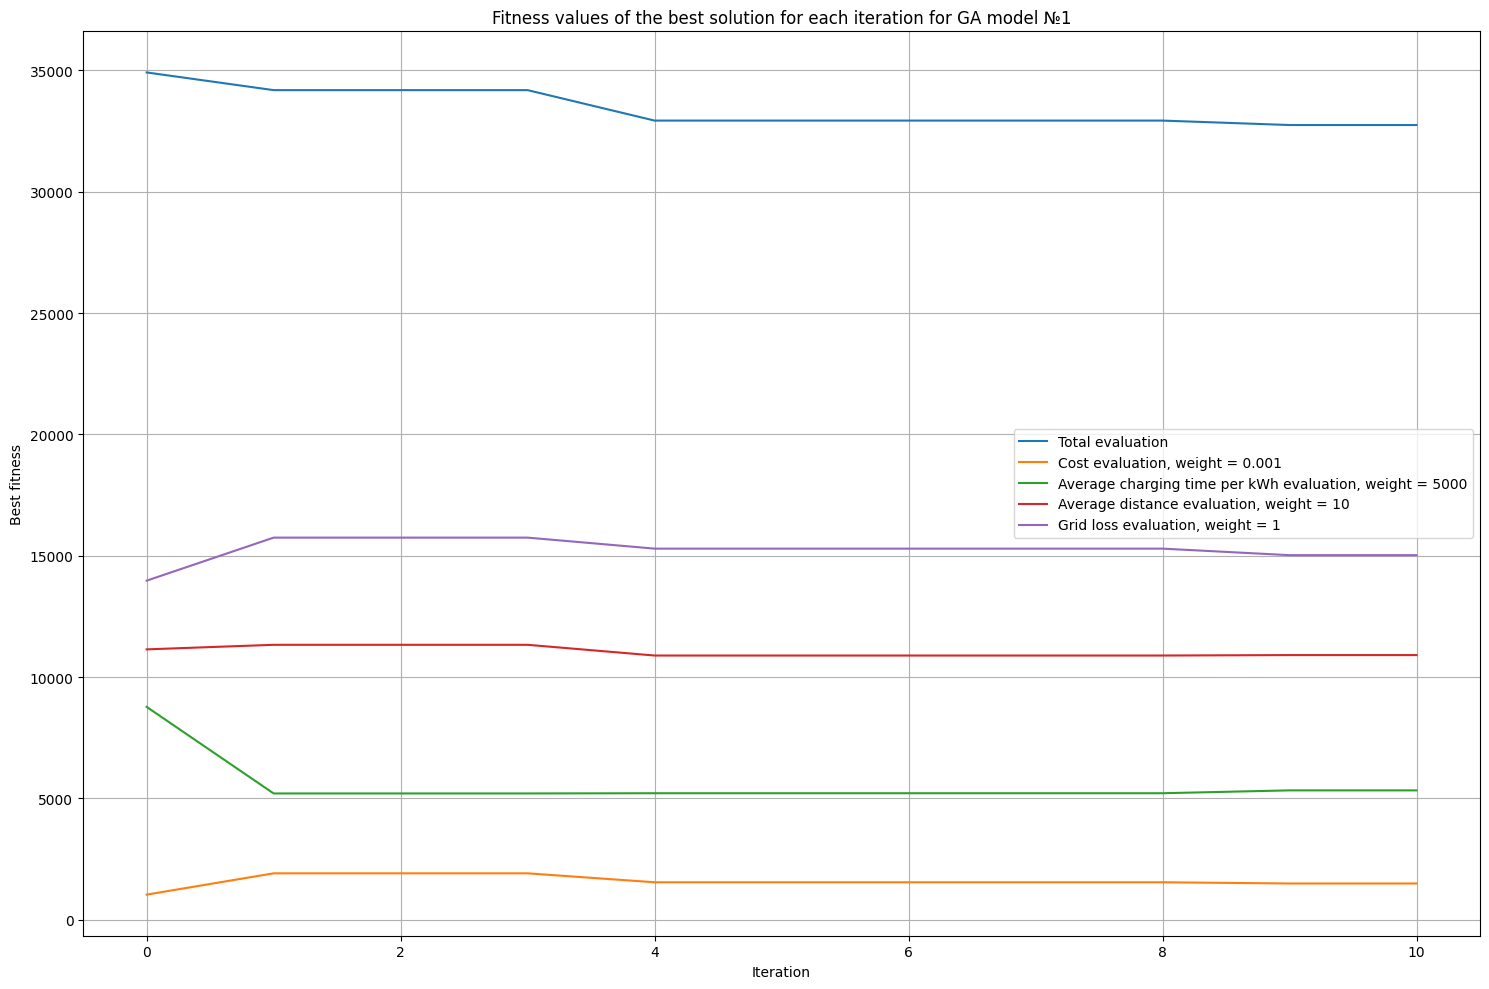

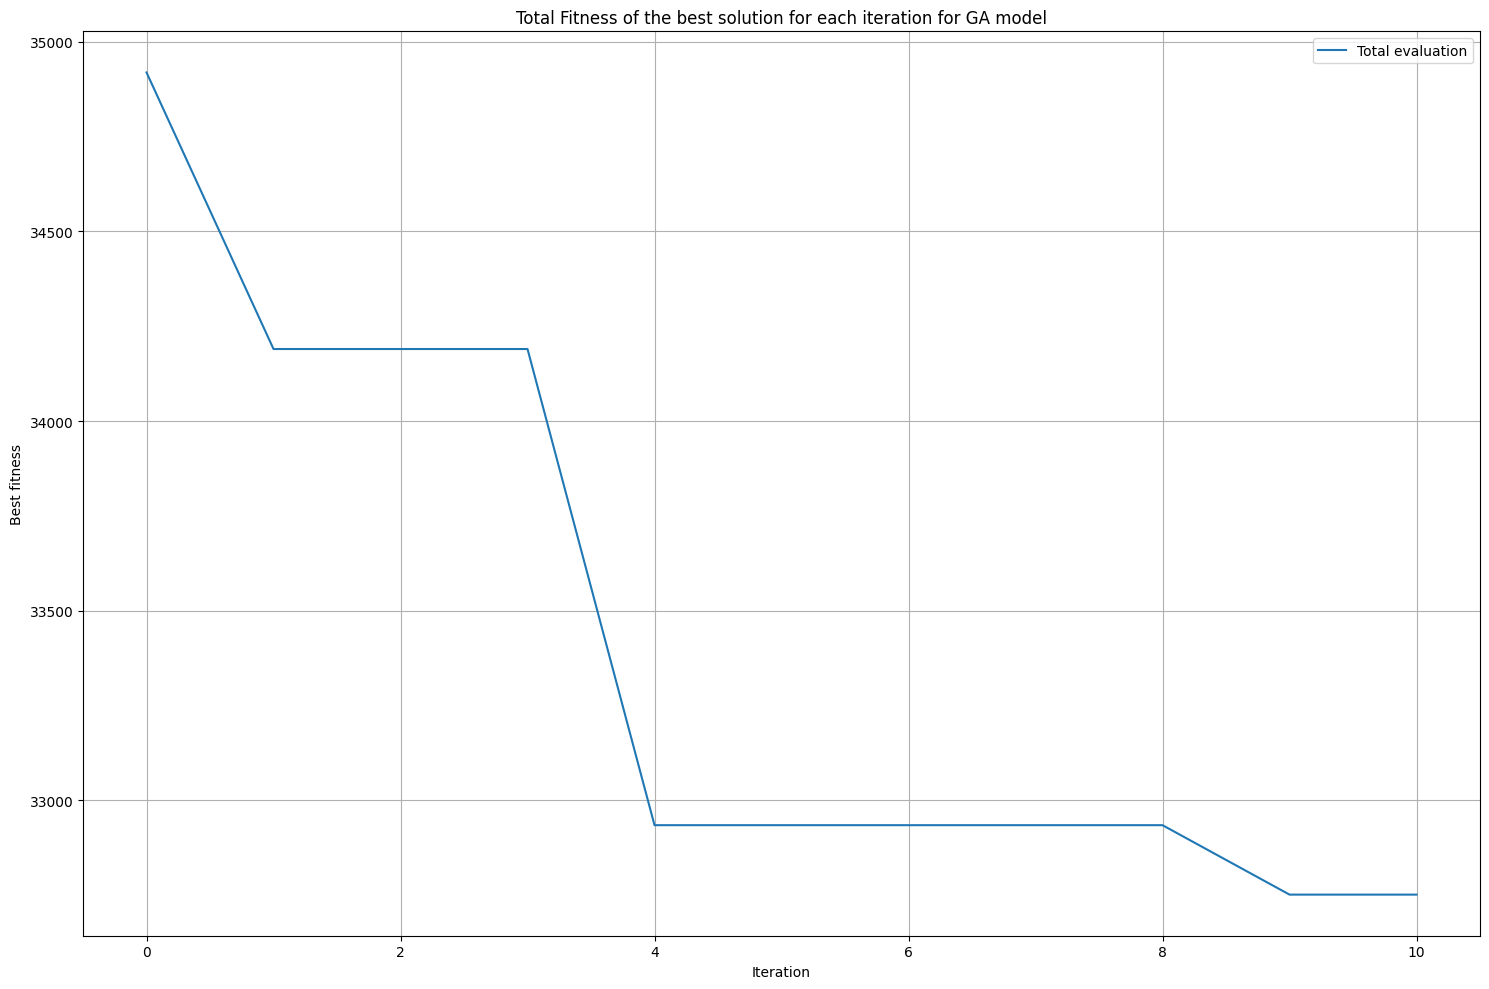

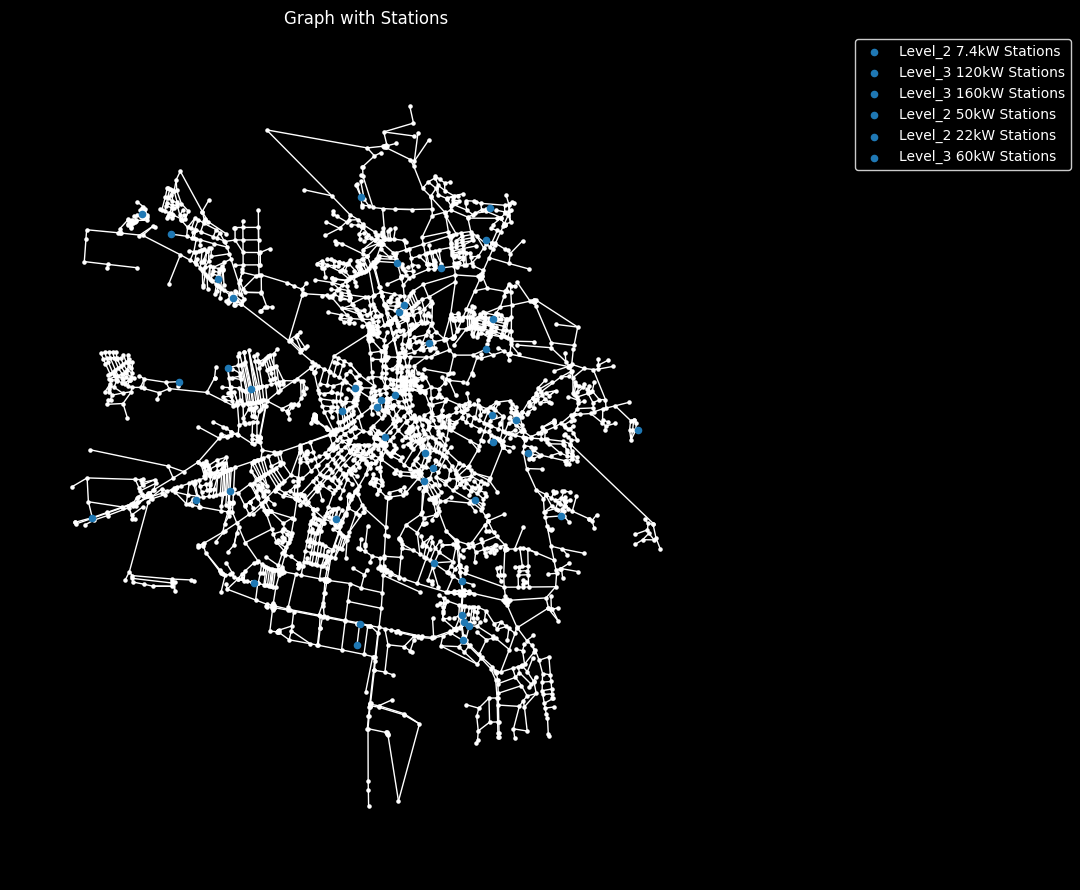

{(1292981322, 'Level_2 7.4kW'): 2,
 (261715094, 'Level_3 120kW'): 3,
 (257541470, 'Level_2 7.4kW'): 1,
 (4396992725, 'Level_2 7.4kW'): 1,
 (1632821514, 'Level_3 160kW'): 1,
 (2139147149, 'Level_2 50kW'): 1,
 (4764650860, 'Level_3 120kW'): 2,
 (386688201, 'Level_2 50kW'): 3,
 (7222924299, 'Level_3 160kW'): 1,
 (2689536849, 'Level_3 120kW'): 1,
 (1634471862, 'Level_2 7.4kW'): 1,
 (1982905671, 'Level_2 7.4kW'): 1,
 (261713142, 'Level_2 22kW'): 1,
 (1642037355, 'Level_3 120kW'): 1,
 (1596335416, 'Level_2 22kW'): 2,
 (11934732539, 'Level_2 7.4kW'): 2,
 (268680403, 'Level_2 7.4kW'): 1,
 (5795253172, 'Level_2 22kW'): 1,
 (1888341318, 'Level_3 160kW'): 2,
 (1935635410, 'Level_3 60kW'): 1,
 (2284836807, 'Level_3 120kW'): 1,
 (268681366, 'Level_2 22kW'): 1,
 (9954237468, 'Level_3 120kW'): 3,
 (4583718368, 'Level_3 160kW'): 1,
 (7394264605, 'Level_2 50kW'): 1,
 (361458283, 'Level_2 7.4kW'): 2,
 (387999227, 'Level_2 50kW'): 1,
 (1802120863, 'Level_3 120kW'): 1,
 (590089499, 'Level_3 160kW'): 2,
 (

In [48]:
GA_optimization_model(city_data, EV_data, CS_data, model_parameters, n = 1)